## Part 1 implementing QAOA


$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

In [25]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [2]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

In [3]:
def one_qaoa_layer(n_qubits, edges, parameters):

    #TODO: implement one qaoa layer
    layer = QRoutine()
    # first half:
    for k in range(n_qubits):
        layer.apply(RX(parameters[k]), k)
    
    # second half:
    for k, (i,j) in enumerate(edges):
        layer.apply(U_ZZ(parameters[n_qubits+k]), i , j)
    
    return layer

In [4]:
from qat.qpus import get_default_qpu

prog_simple = Program()
qubits = prog_simple.qalloc(3)

prog_simple.apply(H, qubits[0])
prog_simple.apply(CNOT, qubits[:2])

circ = prog_simple.to_circ()
job = circ.to_job(nbshots=1)

for op in circ.ops:
    print(op)

qpu = get_default_qpu()

result = qpu.submit(job)
print(result.raw_data[0].state)


Op(gate='H', qbits=[0], type=0, cbits=None, formula=None, remap=None)
Op(gate='CNOT', qbits=[0, 1], type=0, cbits=None, formula=None, remap=None)
|110>


In [5]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters_long, n_layers):
    
    # TODO: implement this.
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    for k in range(n_qubits):
        prog.apply(H, qubits[k])
        
    for l in range(n_layers):
        parameters = parameters_long[l*(n_qubits+len(edges)):(l+1)*(n_qubits+len(edges))]
        prog.apply(one_qaoa_layer(n_qubits, edges, parameters), qubits)
        
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    obs = 0
    for sample in result:
        state_val = 0
        for i,j in edges:
            state_val +=  (1-2*int(sample.state.bitstring[i])) * (1-2*int(sample.state.bitstring[j]))
        obs += sample.probability * state_val
    return obs
    
        

In [6]:
import numpy as np
np.random.random(3)

array([0.50267241, 0.75728174, 0.66074873])

In [26]:
#edges = [(0,1),(0,2),(1,3),(2,3)]
#print(evaluate_parameters(4, edges, np.random.random(32),3
#edges = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
#edges = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
#edges = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5)]

nqubits = 6
edges = [(i,(i+1)%nqubits) for i in range(nqubits)]

# COMPUTATION OF OPT.
best = len(edges)
best_k = 0
for k in range(2**nqubits):
    b = np.binary_repr(k, width=nqubits)
    val = 0
    for i,j in edges:
        val += (1-2*int(b[i])) * (1-2*int(b[j]))
    if val <= best:
        best = val
        best_k = b
        print(best, best_k)
print(best)
print(best_k)

6 000000
2 000001
2 000010
2 000011
2 000100
-2 000101
-2 001001
-2 001010
-2 001011
-2 001101
-2 010001
-2 010010
-2 010011
-2 010100
-6 010101
-6 101010
-6
101010


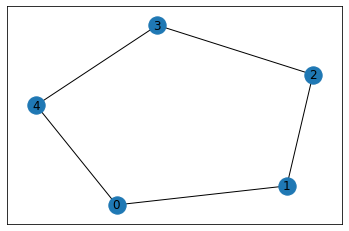

In [19]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [20]:
from scipy.optimize import minimize


### Random initialisation

[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]
-0.23079405522973306
-1.2657582921569368
-1.5907602879929534
-2.157436550126588
-2.7929093905471154
-2.8691792843227195
-2.940629162686561
-2.96211893829594
-2.9787034657057805
-2.9828169286182686
-2.9875737371142197
-2.994041546939951
-2.9976696642162826
-2.998969729214621
-2.9993981791406505
-2.999612280226639
-2.9997819539994657
-2.999873409060882
-2.999945898142919
-2.9999876558911414
-2.9999983756441457
-2.9999998605944778
-2.9999999878223016
-2.9999999994036597
-2.9999999999653273


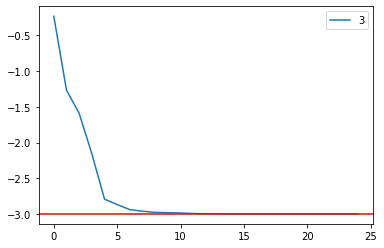

In [22]:
import matplotlib.pylab as plt

tf = 1.

for nlayers in range(3,4,1):
    num_params = (nqubits+len(edges))*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva)

    parameters_init = []
    for l in range(nlayers):
        for k in range(nqubits):
            parameters_init.append(tf*(1-l/float(nlayers)))
        for k in range(len(edges)):
            parameters_init.append(tf*l/float(nlayers))

    print(parameters_init)
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       #parameters_init, 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.legend()
plt.axhline(best,color='r')

### Smart initialization

-0.39357509103023275
-1.2391874258362556
-2.4613393305514943
-2.767447284781929
-2.855042358603359
-2.895642536336153
-2.928553722256893
-2.9500713334481965
-2.9648277569847674
-2.9748130228247716
-2.983695156412324
-2.9876169624123494
-2.9940870668985053
-2.9993070069699934
-2.999702361123453
-2.9998494787820174
-2.999925066450594
-2.99999963914012
-2.999999997110455
-2.9999999985884904
-2.9999999998159397
-2.9999999998892792


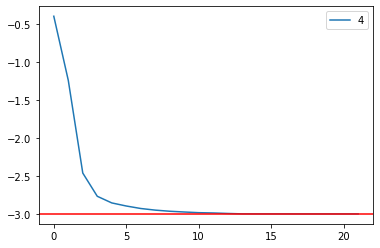

In [23]:
tf = 1.

for nlayers in range(4,5,1):
    num_params = (nqubits+len(edges))*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva)

    parameters_init = []
    for l in range(nlayers):
        for k in range(nqubits):
            parameters_init.append(tf*(1-l/float(nlayers)))
        for k in range(len(edges)):
            parameters_init.append(tf*l/float(nlayers))

        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       #np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.legend()
plt.axhline(best,color='r')

In [24]:
print(opt_res.x)

[ 0.99999855  1.00000007  1.00000088  0.99999946  0.9999971  -1.30460919
 -1.30453868 -1.30487883 -1.30526325 -1.3050306  -0.14795491 -0.14767172
 -0.14782294 -0.14822861 -0.1483164  -0.47047376 -0.47100897 -0.46863454
 -0.46663413 -0.46777676  0.54953593  0.54331659  0.54685345  0.55518232
  0.55680524 -0.67307439 -0.67267734 -0.67446471 -0.67606651 -0.67515067
 -1.16338602 -1.16082463 -1.16226721 -1.16578815 -1.16649625  0.74999924
  0.74999876  0.74999955  0.74999924  0.74999967]


In [12]:
prog = Program()
qubits = prog.qalloc(nqubits)
for k in range(nqubits):
        prog.apply(H, qubits[k])
        
for l in range(nlayers):
    parameters = opt_res.x[l*(nqubits+len(edges)):(l+1)*(nqubits+len(edges))]
    prog.apply(one_qaoa_layer(nqubits, edges, parameters), qubits)

circ = prog.to_circ()
circ.display(fmt='svg')
job = circ.to_job()
result = qpu.submit(job)
proba_vec = []
# ASSERT MOST PROBABLE.
for sample in sorted(result, key=lambda x : x.probability, reverse=True):
    proba_vec.append(sample.probability)
    print(sample.state, sample.probability)

|010101> 0.26817557819321114
|101010> 0.26817557819321114
|001001> 0.023306366655556136
|110110> 0.023306366655556136
|011011> 0.023305529635162667
|100100> 0.023305529635162667
|010010> 0.02330486610157427
|101101> 0.02330486610157427
|011001> 0.02150674088504353
|100110> 0.02150674088504353
|001101> 0.021505918109005873
|110010> 0.021505918109005873
|010011> 0.02150541608707351
|101100> 0.02150541608707351
|010110> 0.021504771865159734
|101001> 0.021504771865159734
|001011> 0.021504323014781588
|110100> 0.021504323014781588
|011010> 0.021504130661634417
|100101> 0.021504130661634417
|010001> 0.0025076161146404315
|101110> 0.0025076161146404315
|011101> 0.0025075456902227504
|100010> 0.0025075456902227504
|010111> 0.002507299838466928
|101000> 0.002507299838466928
|000101> 0.0025072864433719217
|111010> 0.0025072864433719217
|001010> 0.002507005510519026
|110101> 0.002507005510519026
|010100> 0.0025069625979474994
|101011> 0.0025069625979474994
|000111> 0.002141642097355482
|111000> 0

In [13]:
def one_more_realistic_qaoa_layer(n_qubits, edges, parameters,p_noise=0.05):

    layer = QRoutine()
    # first half:
    for k in range(n_qubits):
        layer.apply(RX(parameters[k]), k)
        thresh = np.random.random()
        if thresh <= .5*p_noise:
            layer.apply(X,k)
        if thresh > .5*p_noise and thresh < p_noise:
            layer.apply(Z,k)
            
    
    # second half:
    for k, (i,j) in enumerate(edges):
        layer.apply(U_ZZ(parameters[n_qubits+k]), i , j)
        thresh = np.random.random()
        if thresh <= .5*p_noise:
            layer.apply(X,i)
        if thresh > .5*p_noise and thresh < p_noise:
            layer.apply(Z,i)
        thresh = np.random.random()
        if thresh <= .5*p_noise:
            layer.apply(X,j)
        if thresh > .5*p_noise and thresh < p_noise:
            layer.apply(Z,j)
    
    return layer

In [14]:
def realistic_evaluate_parameters(n_qubits, edges, parameters_long, n_layers,nbruns=1000):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)

    for k in range(n_qubits):
        prog.apply(H, qubits[k])

    for l in range(n_layers):
        parameters = parameters_long[l*(n_qubits+len(edges)):(l+1)*(n_qubits+len(edges))]
        prog.apply(one_qaoa_layer(n_qubits, edges, parameters), qubits)

    circ = prog.to_circ()

    job = circ.to_job(nbshots=nbruns)
    qpu = get_default_qpu()

    results = qpu.submit(job)
    
    meas_list = []

    for sample in results:
        state_val = 0
        #print(sample.state, end=' ')
        for i,j in edges:
            state_val +=  (1-2*int(sample.state.bitstring[i])) * (1-2*int(sample.state.bitstring[j]))
        meas_list.append(state_val)
            
    return np.mean(meas_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


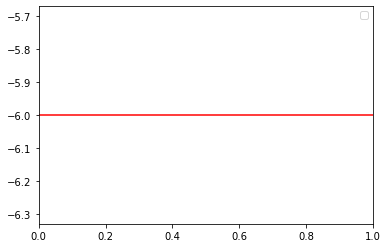

In [15]:
for nlayers in range(1,0,1):
    num_params = (nqubits+len(edges))*nlayers

    back_trace = []
    def print_avg(xk):
        eva = realistic_evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva)

    opt_res = minimize(lambda x : realistic_evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params), 
                       callback=print_avg)
    plt.plot(back_trace,label=str(nlayers))
plt.legend()
plt.axhline(best,color='r')